# *Statistics coded:* Trade, investment and employment as aspects of globalisation 

Prepared by **D.Gojsic** ([_Eurostat_](https://ec.europa.eu/eurostat), task force Peer Reviews and Quality).

This notebook aims at reproducing the figures/graphs of the *Statistics Explained*  article on [**Trade, investment and employment as aspects of globalisation**](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Trade,_investment_and_employment_as_aspects_of_globalisation).

## Configuration

* Import necessary packages and set global properties, such as countrynames for EU28 and corresponding labels

In [1]:
try:
  import google.colab
  !pip install eurostatapiclient
except:
  pass

/srv/conda/envs/notebook/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
## %%bash
## [[ ! -e /colabtools ]] && exit
## pip install eurostatapiclient

In [3]:
from eurostatapiclient import EurostatAPIClient
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression

legend_properties = {'weight':'bold','size':'12'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 
                   'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark', 'EE':'Estonia', 
                   'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 
                   'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT': 'Malta', 
                   'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'UK':'United Kingdom', 
                   'EU28': 'EU-28', 'EU27_2020':'EU-27'}
countries_abbr = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 
                  'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NV', 'NL', 'PL', 
                  'PT', 'RO', 'SE', 'SI', 'SK', 'UK', 'MT', 
                  'EU28']

* Set up `eurostatapiclinet` by supplying settings, which will stay the same throught

In [4]:
#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

* Define  Functions for graphing

In [5]:
def subcategorybar(X,vals,lower,upper,distance,col,rot,width=0.6):
    ax.grid(axis='y', color='silver', linestyle='--', linewidth=1)
    n = len(vals)
    _X = np.arange(len(X))
    X_ticks=np.insert(np.append(_X,_X[-1]+1), _X[0],_X[0]-0.5)

    [plt.bar(_X - width/2. + i/float(n)*width, vals[i],
             width=width/float(n), align="edge", zorder=2, color=col[i])
    for i in range(n)]
        
    ax.set_xlim(left=X_ticks[0],right=X_ticks[-1]-0.5)
    ax.tick_params(axis='x', which='minor', length=0)    
    ax.set_xticks(_X, minor=True)
    ax.set_xticklabels(X, minor = True)
    ax.set_xticks(X_ticks-0.5, minor=False)
    ax.set_xticklabels('', minor=False)
    
    Y_ticks=range(lower,upper,distance)
    ax.set_yticks(Y_ticks)
    new_ticks= [str(i)+'%'for i in Y_ticks]
    new_ticks[0]='%'
    ax.set_yticklabels(new_ticks)
    ax.tick_params(axis='y', which='major', length=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    [tick.set_rotation(rot) for tick in ax.get_xticklabels(minor=True)]

In [6]:
def hcatbar(Y,cats,lower,upper,col,labsize,barsize,width=0.6): 
    y_pos = np.arange(len(cats))
    if any(Y)>0:
        ax.barh(y_pos, Y,align='center', 
                color= (Y < 0).map({True: col[0], False: col[1]}), 
                zorder=2, height=barsize)
        ax.spines['left'].set_position('zero')
    else:
        ax.barh(y_pos, Y,align='center', color= col, zorder=2, height=barsize)
        
    ax.set_xlim(lower,upper)
    ax.set_yticks(y_pos)
    ax.tick_params(axis='y', which='major', labelsize=labsize, length=0)
    ax.set_yticklabels(cats)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        label.set_horizontalalignment('left' if(Y[n]<0) else 'right')
        
    for n, tick in enumerate(ax.get_yaxis().get_major_ticks()):
        if(Y[n]>=0): continue
        tick.set_pad(-4)

    ax.grid(axis='x', color='silver', linestyle='--', linewidth=1)
    ax.tick_params(axis='x', which='major', length=0)

* Set parameters for data of interest and retrieve requested data. 
* Clean and wrangle data so that it is usable, by filtering `NANs` and pivoting, so the final dataframe consists of two columns, which will be graphed as bars

In [7]:
par_df1 = {
    'na_item': ['P6','P7'],
    'sinceTimePeriod': '2010',
    'geo':'EU27_2020',
    'unit':'PC_GDP'
}

df1 = client.get_dataset('nama_10_gdp', params=par_df1).to_dataframe()

par_df1.update({'lastTimePeriod': '2020'})
df1 = (df1[df1.time <= par_df1['lastTimePeriod']]
       .pivot(index='time', columns='na_item', values='values')
       .reset_index()
       .rename(columns={'P6':'Exports', 'P7':'Imports'})
       )

## International trade

### Figure 1: EU-27 imports and exports in percentage of GDP by year

Use options as laid out in the function above. Additionally, define patches for custom legend and provide custom Title

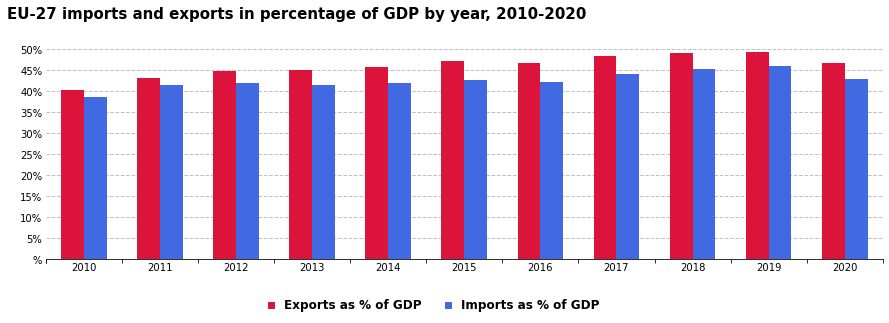

In [8]:
#make plot
fig, ax = plt.subplots(figsize=(15, 4))

subcategorybar(df1['time'], [df1['Exports'], df1['Imports']], 
               0, 55, 5, ['crimson','royalblue'], 0)
red_patch = mpatches.Patch(color='crimson', label='Exports as % of GDP')
blue_patch = mpatches.Patch(color='royalblue', label='Imports as % of GDP')
leg = ax.legend(handles=[red_patch,blue_patch],frameon=False, loc=(0.26, -0.26), 
                ncol=2, prop=legend_properties, labelspacing=0.1, handlelength=0.5)
[patch.set_height(6) for patch in leg.get_patches()]
ax.set_title('{} imports and exports in percentage of GDP by year, {}-{}'
             .format(countries_names[par_df1['geo']],par_df1['sinceTimePeriod'],par_df1['lastTimePeriod']),
             fontsize=15,fontweight='bold',y=1.08, x=0.3)

plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe, and sorting it for graphing

In [9]:
#df2 manipulation
par_df2 = {
    'na_item': ['P6','P7'],
    'time': '2018',
    'geo':countries_abbr,
    'unit':'PC_GDP'
}

df2 = client.get_dataset('nama_10_gdp', params=par_df2).to_dataframe()
df2 = (df2
       .pivot(index='geo', columns='na_item', values='values')
       .reset_index()
       .rename(columns={'P6':'Exports', 'P7':'Imports'})
       )
df2['geo'] = df2['geo'].map(countries_names)
df2 = df2.sort_values(by='Exports', ascending=False)

### Figure 2: Imports and exports in percentage of GDP by country

Add custom legend, title.

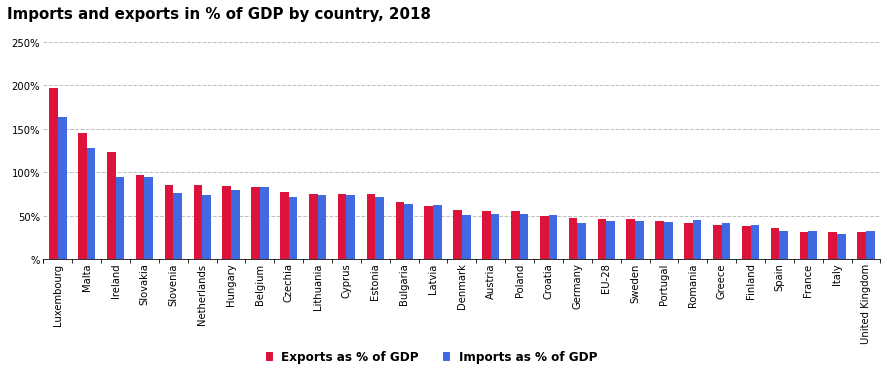

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
subcategorybar(df2['geo'], [df2['Exports'], df2['Imports']], 
               0,300,50, ['crimson','royalblue'],90)

#patches are set with the corresponding labels
red_patch = mpatches.Patch(color='crimson', label='Exports as % of GDP')
blue_patch = mpatches.Patch(color='royalblue', label='Imports as % of GDP')

leg= ax.legend(handles=[red_patch,blue_patch],frameon=False, loc=(0.26, -0.5), 
               ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)
    
ax.set_title('Imports and exports in % of GDP by country, {}'
              .format(par_df2['time']),fontsize=15,fontweight='bold',y=1.08, x=0.21)

plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe, and sorting it for graphing

In [11]:
par_df3={
    'na_item': ['P6','P7'],
    'time': '2018',
    'geo':[countries_abbr,'EU28'],
    'unit':'PC_GDP'
}

df3 = (client.get_dataset('nama_10_gdp', params=par_df3)
       .to_dataframe()
       .pivot(index='geo', columns='na_item', values='values')
       .reset_index()
       .rename(columns={'P6':'Exports', 'P7':'Imports'})
       )
# issues with some pandas version, including on Google colab... ? we use methods for regular operations
df3['balance'] = (df3['Exports']
                   .sub(df3['Imports'])
                   .div(df3['Exports']) 
                   )
# df3['balance']=(df3['Exports'] - df3['Imports']) /df3['Exports']

df3['geo'] = df3['geo'].map(countries_names)
df3 = (df3
       .sort_values(by='balance', ascending=True)
       .reset_index(drop=True)
       )

### Figure 3: Export-Import balance by country

Add custom legend, title.

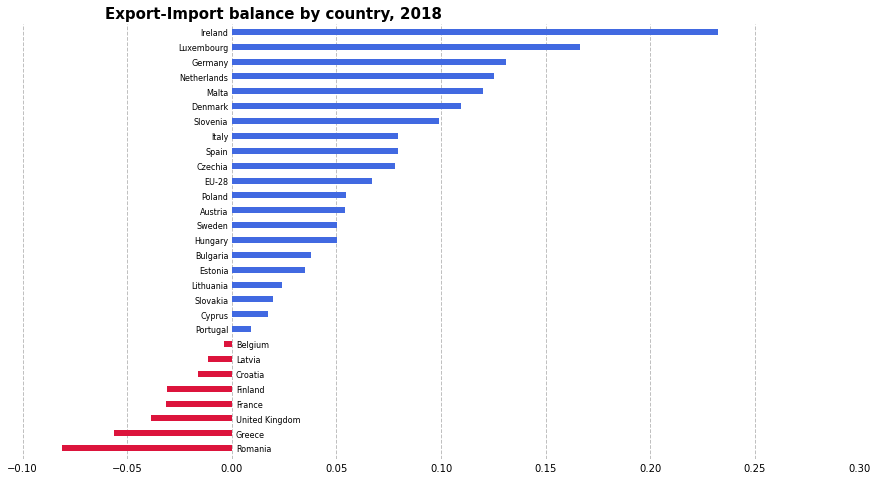

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
hcatbar(df3['balance'], df3['geo'], 
        -0.1, 0.3, ['crimson', 'royalblue'], 8,0.4)
ax.set_ylim(-0.75,28.5)
ax.set_title('Export-Import balance by country, {}'
             .format(par_df3['time']),fontsize=15,fontweight='bold',y=1.00, x=0.3)
plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe, and calculating quantities of interest to be graphed

In [13]:
par_df4_bop = {
    'fdi_item': ['DO__D__F','DI__D__F'],
    'precision': '0',
    'geo':'EU28',
    'partner':'EXT_EU28',
    'stk_flow':['NO','NI'],
    'currency':'MIO_EUR',
    'entity':'TOTAL',
    'nace_r2':'FDI'
}

par_df4_gdp={
    'unit':'CP_MEUR',
    'na_item': 'B1G',
    'time':['2013','2014','2015','2016','2017'],
    'geo':'EU28',
    'nace_r2':'TOTAL'
}

df4_bop = client.get_dataset('bop_fdi6_pos', params=par_df4_bop).to_dataframe().dropna()
df4_gdp = client.get_dataset('nama_10_a64', params=par_df4_gdp).to_dataframe()

df4 = (df4_bop
        .merge(df4_gdp[['values','time']], how='left', left_on='time', right_on='time')
        )
df4['per_gdp'] = (df4['values_x']
                  .div(df4['values_y'])
                  .apply(lambda x: x*100)  
                  )
# df_4['per_gdp'] = (df_4['values_x']/df_4['values_y'])*100
df4 = (df4
       .pivot(index='time', columns='stk_flow', values='per_gdp')
       .reset_index()
       .rename(columns={'NI':'Inward', 'NO':'Outward'})
       )

## Foreign direct investment

### Figure 4: Inward and outward foreign direct investment stocks relative to the rest of the world as a percentage of GDP

Add custom legend, title.

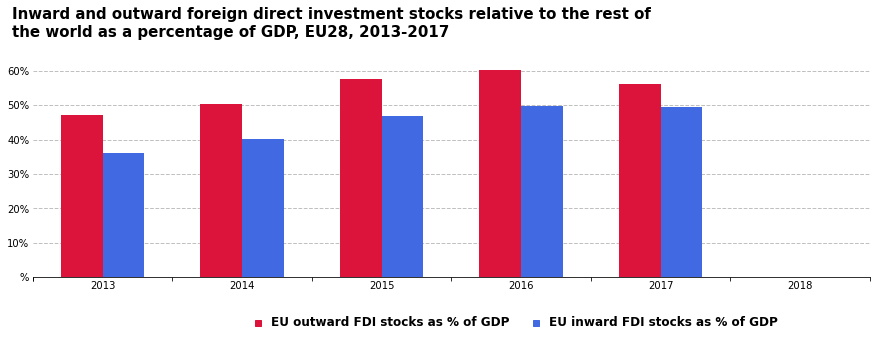

In [14]:
#make plot
fig, ax = plt.subplots(figsize=(15, 4))
subcategorybar(df4['time'],  [df4['Outward'],df4['Inward']], 
               0,70,10, ['crimson','royalblue'],0)
red_patch = mpatches.Patch(color='crimson', label='EU outward FDI stocks as % of GDP')
blue_patch = mpatches.Patch(color='royalblue', label='EU inward FDI stocks as % of GDP')

leg= ax.legend(handles=[red_patch,blue_patch],frameon=False, loc=(0.26, -0.26), 
               ncol=2, prop=legend_properties,labelspacing=0.1, handlelength=0.5)
[patch.set_height(6) for patch in leg.get_patches()]
ax.set_title('Inward and outward foreign direct investment stocks relative to the rest of \nthe world as a percentage of GDP, {}, {}-{}'
              .format(par_df4_gdp['geo'],min(par_df4_gdp['time']),max(par_df4_gdp['time'])),
             fontsize=15,fontweight='bold',y=1.08, x=-0.025, loc='left')
plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe, and calculating quantities of interest to be graphed, additionally sort out outliers as defined in source graphs

In [15]:
par_df5_bop={
    'fdi_item': ['DO__D__F','DI__D__F'],
    'precision': '0',
    'geo':countries_abbr,
    'partner':'WRL_REST',
    'stk_flow':['NO','NI'],
    'currency':'MIO_EUR',
    'time':'2017',
    'entity':'TOTAL',
    'nace_r2':'FDI'
}

par_df5_gdp={
    'unit':'CP_MEUR',
    'na_item': 'B1G',
    'time':'2017',
    'geo':countries_abbr,
    'nace_r2':'TOTAL'
}

In [ ]:
df5_bop = client.get_dataset('bop_fdi6_pos', params=par_df5_bop).to_dataframe().dropna()
df5_gdp = client.get_dataset('nama_10_a64', params=par_df5_gdp).to_dataframe()

df5 = (df5_bop
       .merge(df5_gdp[['values','geo']],how='left', left_on='geo', right_on='geo')
      )
df5['per_gdp'] = df5['values_x'].div(df5['values_y']).apply(lambda x: x*100)  
# df5['per_gdp'] = (df5['values_x']/df5['values_y'])*100

df5 = (df5
       .pivot(index='geo', columns='stk_flow', values='per_gdp')
       .reset_index()
       .rename(columns={'NI':'Inward', 'NO':'Outward'})
      )

df6 = df5.copy()

outlier = df5.loc[df5['geo'].isin(['IE','MT','CY','LU','NL'])]
df5 = (df5
       .loc[df5['geo'].isin(['IE','MT','CY','LU','NL','EU28'])==False]
       .reset_index()
      )

### Figure 5: Inward and outward foreign direct investment by Member State

Emulate style manually and add labels to observations. In addition, add a linear approximation for purposes of data exploration.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.grid(axis='y', color='silver', linestyle='--', linewidth=0.75)
ax.grid(axis='x', color='silver', linestyle='--', linewidth=0.75)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(left=0,right=160)
ax.set_ylim(0,200)

ax.tick_params(axis='y', which='major', length=0)

for i,type in enumerate(df5['geo']):
    x, y = df5['Outward'][i], df5['Inward'][i]
    ax.scatter(x, y, marker='.', color='royalblue')
    ax.text(x-1, y+3, type, fontsize=9)

z = np.polyfit(df5['Outward'], df5['Inward'], 1)
p = np.poly1d(z)
plt.plot(df5['Outward'],p(df5['Outward']),"r")

ax.set_title('Inward and outward foreign direct investment by Member State, in percentage of GDP, {}'
              .format(par_df5_gdp['time']),
             fontsize=15,fontweight='bold',y=1.08, x=-0.025, loc='left')
plt.xlabel('EU outward FDI stocks as % of GDP')
plt.ylabel('EU inward FDI stocks as % of GDP')

plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe

In [ ]:
df6['balance'] = (df6['Outward']
                  .div(df6['Inward'])
                  .apply(lambda x: x-1)
                  )
# df6['balance'] = (df6['Outward']/df6['Inward'])-1

df6['geo'] = df6['geo'].map(countries_names)
df6 = (df6
       .sort_values(by='balance', ascending=True)
       .reset_index(drop=True)
      )

### Figure 6: Inward-Outward FDI balance ratio by Member State

Add custom legend, title.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
hcatbar(df6['balance'], df6['geo'], -1.20, 1, ['crimson', 'royalblue'], 8,0.4)
ax.set_ylim(-0.75,28.5)
ax.set_xlim(-1.3,0.9)
ax.set_title('Inward - Outward FDI balance ratio by Member State, {}'.format(par_df5_gdp['time']),
             fontsize=15,fontweight='bold',y=1.00, x=0.3)
plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe and calculating quantities of interest to be graphed

In [ ]:
par_df7={
    'precision':1,
    'geo':'EU28',
    'indic_sb':'V16110',
    'time':['2013','2014','2015','2016'],
    'c_ctrl':['EXT_EU28','WORLD'],
    'nace_r2':'B-N_S95_X_K'
}

df7 = client.get_dataset('fats_g1a_08', params=par_df7).to_dataframe()
df7 = (df7
       .pivot(index='time', columns='c_ctrl', values='values')
       .reset_index()
      )
df7['perc'] = df7['EXT_EU28'].div(df7['WORLD']).apply(lambda x : round(x*100,2))
# df7['perc'] = round(((df7['EXT_EU28']/df7['WORLD'])*100),2)

## Employment

### Figure 7: Employment shares of enterprises controlled from outside the EU-28 in total EU employment by year

Add custom legend, title, insert percentage labels above the bars.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
subcategorybar(df7['time'], [df7['perc']], 0,8,1, ['royalblue'],0)
ax.set_title('Employment shares of enterprises controlled from outside the {} in total EU employment by year, {}-{}'
             .format(par_df7['geo'],min(par_df7['time']),max(par_df7['time'])),
             fontsize=15,fontweight='bold',y=1.08, x=0.55)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', length=0)
ax.set_yticklabels('', minor=False)

for p in ax.patches: 
  ax.annotate(p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
              ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Request and wrangle data so that it is usable, by pivoting dataframe and calculating quantities of interest to be graphed, mapping countrynames and sorting

In [ ]:
par_df8 = {
    'precision':1,
    'geo':countries_abbr,
    'indic_sb':'V16110',
    'time':'2016',
    'c_ctrl':['WRL_X_REP','WORLD'],
    'nace_r2':'B-N_S95_X_K'
}

df8 = client.get_dataset('fats_g1a_08', params=par_df8).to_dataframe()
df8 = (df8
       .pivot(index='geo', columns='c_ctrl', values='values')
       .reset_index()
      )
df8['perc'] = (df8['WRL_X_REP']
               .div(df8['WORLD'])
               .apply(lambda x: x*100)
              )
#df8['perc'] = (df8['WRL_X_REP']/df8['WORLD'])*100
df8['geo'] = df8['geo'].map(countries_names)
df8 = (df8
       .sort_values(by='perc', ascending=True)
       .reset_index(drop=True)
      )

### Figure 8: Employment shares of foreign controlled enterprises (world except reporting country) in total domestic employment by country

Add custom legend, title, color EU28 bar blue.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
hcatbar(df8['perc'], df8['geo'], 0, 50, 'crimson', 8,0.4)
ax.set_ylim(-0.75,28.5)
ax.set_title('Employment shares of foreign controlled enterprises (world except \nreporting country) in total domestic employment by country, {}' 
             .format(par_df8['time']),
             fontsize=15,fontweight='bold',y=1.05, x=-0.06, loc='left')
ax.spines['left'].set_visible(True)
ax.get_children()[11].set_color('royalblue')
plt.show()